In [1]:
import os 
import numpy as np
import tensorflow as tf
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "COMPRESSED"

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']= (12,12)
mpl.rcParams['axes.grid'] = False

import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*225
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
pip install keras~=2.6.0 --user

  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow~=2.6.0 --user

  Using cached tensorflow-2.6.3-cp39-cp39-win_amd64.whl (428.9 MB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import get_file

In [7]:
content_path = get_file(fname="Optimus_Prime-Transformers.jpg",origin="https://s3-us-west-2.amazonaws.com/prd-rteditorial/wp-content/uploads/2021/06/25160730/Optimus_Prime-Transformers_2007-Ketchup.jpg")
style_path = get_file(fname="Steve-Huston.jpg",origin="https://www.artmentors.com/wp-content/uploads/2016/12/Steve-Huston-www.kaifineart.com-10.jpg")

In [8]:
#content_path = get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [9]:
#Define a function to load an image and limit its max dimension to 512 pixels
def load_img(path_to_image):
    max_dim = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [10]:
#create simple function to display an image:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

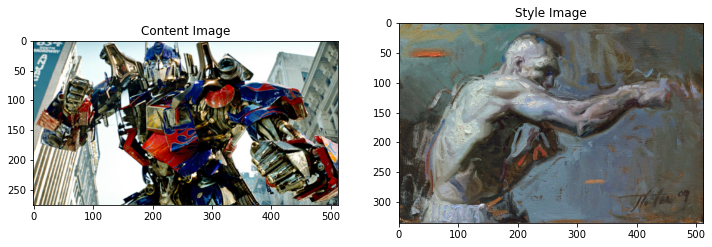

In [11]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')


In [12]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [13]:
from tensorflow.keras.layers import LayerNormalization

In [14]:
#tf.compat.v1.estimator.experimental.dnn_logit_fn_builder

In [15]:
pip install --upgrade tensorflow-estimator==2.6.0

Note: you may need to restart the kernel to use updated packages.


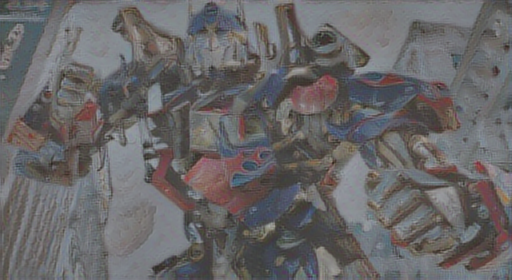

In [16]:
#Fast style transfering using TF-Hub
#Demonstrating the original style-transfer algorithm, let's see the 
#TensorFlow Hub Model implement this

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [17]:
#Define content and style representations, starting from the network's input layer
#first few layers activations represent low-level features like edges and textures.
#The final few layers represent higher-level features-object parts like wheels and eyes.

#Using a VGG19 network architecture, a pretrained image classification network. Intermediate
#layers are necessary to define the representation of content and style from the images.
#For an input image, try to match the correspoinding style and content target representations 
#at these intermediate layers.



In [18]:
#Testing out a VGG19 on our image:

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top= True, weights = 'imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [19]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('ski', 0.96228975),
 ('bobsled', 0.013078867),
 ('dogsled', 0.0066990494),
 ('snowmobile', 0.0065514836),
 ('stupa', 0.0038196724)]

In [20]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [21]:
#Choose intermediate layers from the network to represent the style and content of the image:

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Intermediate Layers for Style and Content

How do the intermediate outputs within our pretrained image classification network allow us to define style and content representations? 


At a high level, in order for a network to perform image classification (which the network has been trained to do), it must understand the data of the image. Taking the raw image as data pixels and building an internal representaion that converts the pixels into a complex understanding of the features present within the image.

This is also the reason why convulational neural networks are able to generalize well: they're able to capture the invariances and defining features within classes (e.g. cats v dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between the raw image is fed into the model and the output classification label, the model serves as a  ***complex feature extractor***. By accessing intermediate layers of the model, you're able to describe the content and style of input images.


# Now to Build the Model

In [22]:
def vgg_layers(layer_names):
    " " " Creates a vgg model that returns a list of intermediate output values." " "
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top = False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [23]:
#Create the model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())
    print()

block1_conv1
 shape:  (1, 336, 512, 64)
 min:  0.0
 max:  783.156
 mean:  18.27507

block2_conv1
 shape:  (1, 168, 256, 128)
 min:  0.0
 max:  3039.3496
 mean:  105.794174

block3_conv1
 shape:  (1, 84, 128, 256)
 min:  0.0
 max:  6876.433
 mean:  94.56221

block4_conv1
 shape:  (1, 42, 64, 512)
 min:  0.0
 max:  13719.212
 mean:  413.86166

block5_conv1
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  2137.0774
 mean:  31.625332



### Calculate Style 

Content of the images is represented by the values of the  intermediate feature maps.

It turns out that the style of the image can be represented/described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer productof the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

                        G = (SUM(i,j)F(i,j,c)(x)F(i,j,d)(x))/IJ
                        
This can be implemented concisely using `tf.linalg.einsum` function:

In [24]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

### Extract style and content

###### Build a model that returns the style and content tensors. 


In [25]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         
                        for style_output in style_outputs]
        
        content_dict = {content_name: value
                       for content_name, value
                       in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value
                     for style_name, value
                     in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [26]:
from __future__ import division

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers:`

In [27]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles: ')
for name, output in sorted(results['style'].items()):
    print(" ", name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())
    print()
    
    
print('Contents: ')
for name, output in sorted(results['content'].items()):
    print(" ", name)
    print(" shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print(" max: ", output.numpy().max())
    print(" mean: ", output.numpy().mean())
    print()

Styles: 
  block1_conv1
 shape:  (1, 64, 64)
 min:  0.17935863
 max:  43007.31
 mean:  1123.7334

  block2_conv1
 shape:  (1, 128, 128)
 min:  0.0
 max:  311091.22
 mean:  43416.17

  block3_conv1
 shape:  (1, 256, 256)
 min:  0.0
 max:  809604.44
 mean:  46286.08

  block4_conv1
 shape:  (1, 512, 512)
 min:  0.0
 max:  11796959.0
 mean:  542157.1

  block5_conv1
 shape:  (1, 512, 512)
 min:  0.0
 max:  186271.1
 mean:  4044.42

Contents: 
  block5_conv2
 shape:  (1, 17, 32, 512)
 min:  0.0
 max:  1469.7043
 mean:  24.458042



### Run gradient descent

*With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then weighted sum of these losses.

###### Set your style and content target values:

In [28]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize.

Initialize with the content image (the `tf.Variable` must be the same shape as the content image):

In [29]:
image = tf.Variable(content_image)

In [30]:
#Define a function to keep the pixel values between 0 and 1:

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### L-BFGS (Limited Memory Broyden-Fletcher-Goldfarb-Shanno)

A popular machine learning algorithm for paramter estimation, it's target is to minimize the *f(x)* over unconstrained values of the real vector **X** where *f* is a differentiable scalar function

In [31]:
#Create an optimizer, the paper recommends LBFGS, `Adam` works okay as well

opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [32]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n( [ tf.reduce_mean( ( style_outputs[name]-style_targets[name] )**2 ) for name in style_outputs.keys() ] )

    style_loss *= style_weight/num_style_layers
    
    content_loss = tf.add_n( [ tf.reduce_mean( ( content_outputs[name]-content_targets[name] )**2 ) for name in content_outputs.keys()] )
   
    content_loss *= content_weight/num_content_layers
    loss = style_loss + content_loss
    
    return loss

    

In [33]:
# outputs = extractor(image)

# style_outputs = outputs['style']
# content_outputs = outputs['content']

# style_loss = tf.add_n( [ tf.reduce_mean( ( style_outputs[name]-style_targets[name] )**2 ) for name in style_outputs.keys() ] )

# print(style_loss)
# style_loss *= style_weight/num_style_layers
# print(style_loss)
# content_loss = tf.add_n( [ tf.reduce_mean( ( content_outputs[name]-content_targets[name] )**2 ) for name in content_outputs.keys()] )
# print(content_loss)
# content_loss *= content_weight/num_content_layers
# print(content_loss)
# loss = style_loss + content_loss
# print("the loss function",loss)

In [34]:
print(extractor(image))

{'content': {'block5_conv2': <tf.Tensor: shape=(1, 17, 32, 512), dtype=float32, numpy=
array([[[[ 49.974724 ,  96.89902  ,   0.       , ...,   0.       ,
          185.4568   ,   0.       ],
         [ 70.879005 , 225.00586  ,   0.       , ...,   0.       ,
          300.97305  ,   0.       ],
         [  0.       , 204.04045  ,   0.       , ...,   0.       ,
          190.36177  ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   1.6067746],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
           49.4456   , 320.0042   ],
         [  0.       ,   0.       ,  50.19171  , ...,   0.       ,
          221.11554  , 294.09186  ]],

        [[  0.       , 233.83162  ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       , 280.59402  ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       , 140.29648  ,   0.       , ...,   0.       

Use `tf.GradientTape` to update the image.

In [35]:
@tf.function()
@tf.autograph.experimental.do_not_convert #eliminate ugly error that shows up as an output in the very next cell
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))

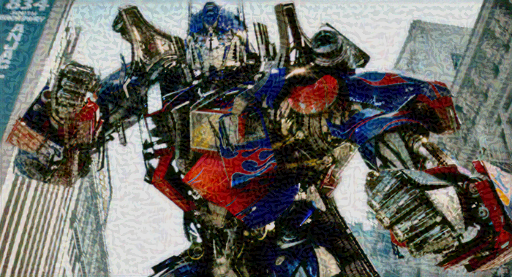

In [36]:
train_step(image)
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Well, since it's starting to work now...

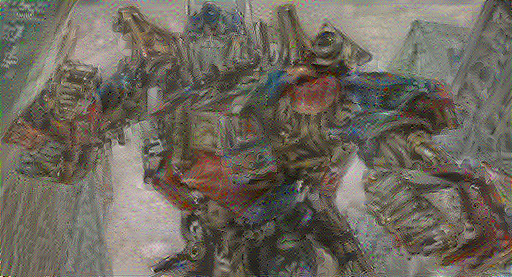

Train step: 1000
Total time: 2809.6


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


### Total variation loss


One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [38]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    return x_var, y_var

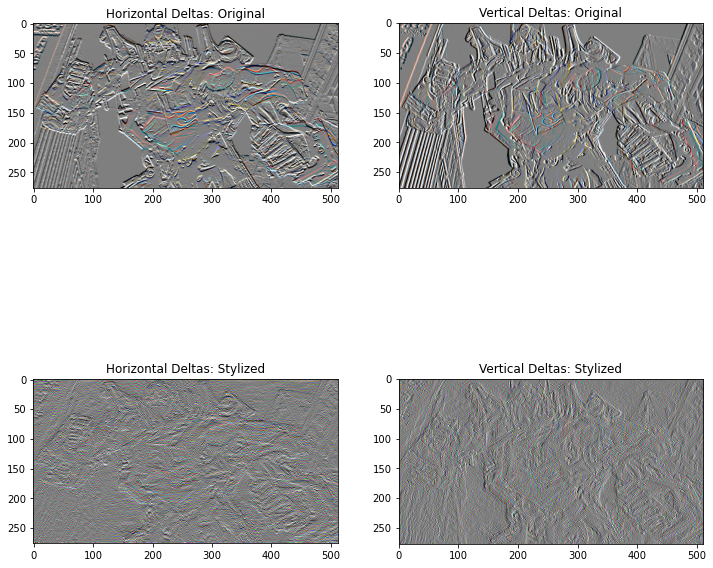

In [39]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize = (12,12))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Stylized")

plt.subplot(2, 2, 4) 
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Stylized")

In [40]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [41]:
total_variation_loss(image).numpy()

81667.56

In [42]:
tf.image.total_variation(image).numpy()

array([81667.56], dtype=float32)

Choose a weight for the `total_variation_loss`:

Including it in `train_step`


In [43]:
total_variation_weight = 30

In [44]:
@tf.function()
@tf.autograph.experimental.do_not_convert #eliminate ugly error that shows up as an output in the very next cell
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += [(total_variation_weight)*(tf.image.total_variation(image))]
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [45]:
image = tf.Variable(content_image)

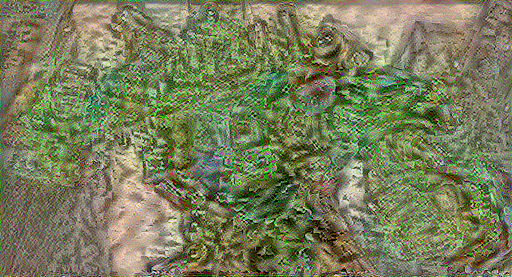

Train step: 200
Total time: 701.8


In [46]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### SAVE IT!!

In [47]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
      from google.colab import files
except ImportError:
    pass
else:
    files.download(file_name)